In [1]:
from scipy.spatial.transform import Rotation
from inchworm_measurement.laser import Laser
from inchworm_measurement import utils
from pprint import pprint
from inchworm_measurement.simulator import Simulator
from matplotlib import pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
%matplotlib inline

共通設定


In [2]:

sigma = 0.00489  # size of pixel [mm] (nikon D800)
focal = 8  # length of focal [mm] (NIKKOR 8-15mm f/3.5-4.5E)

A = np.array([
    [focal/sigma, 0, 0],
    [0, focal/sigma, 0],
    [0, 0, 1]
])

M_raw = [
    np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, z],
        [0, 0, 0, 1]
    ]) for z in np.linspace(0, 4000, 40, endpoint=False)
]+[
    np.array([
        [np.cos(theta), 0, np.sin(theta), 2000-2000*np.cos(theta)],
        [0, 1, 0, 0],
        [-np.sin(theta), 0, np.cos(theta), 4000+2000*np.sin(theta)],
        [0, 0, 0, 1]
    ]) for theta in np.linspace(0, np.pi/2, 40, endpoint=False)
]+[
    np.array([
        [0, 0, 1, x],
        [0, 1, 0, 0],
        [-1, 0, 0, 6000],
        [0, 0, 0, 1]
    ]) for x in np.linspace(2000, 10000, 80, endpoint=False)
]
wMc_raw = M_raw[:100]
wMs_raw = M_raw[20:110]
cMr = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 500],
        [0, 0, 0, 1]
    ])


軌跡チェック

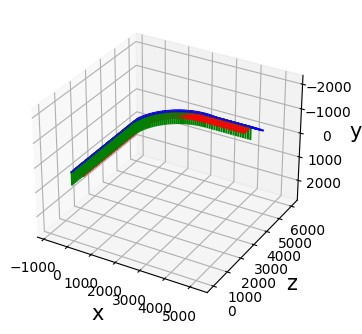

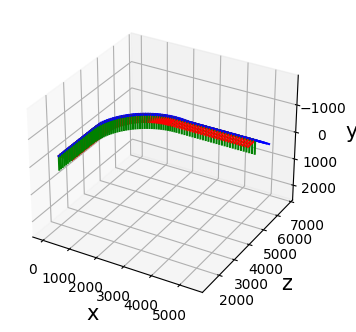

In [3]:
utils.plot_pose(wMc_raw, axis_length=500)
utils.plot_pose(wMs_raw, axis_length=500)


点群生成


In [162]:
surface_functions = {
    "eq": [
        lambda x, y, z: (x - 2000) * (x + 2000) * (y - 2000) * (y + 2000) * (z - 4000) * (z - 8000),
    ],
    "ineq": [
        lambda x, y, z: -2000.1 <= y and y <= 2000.1,
        lambda x, y, z: -2000.1 <= x and x <= 2000.1 and -0.1 <= z and z <= 8000.1,
        lambda x, y, z: -2000.1 <= x and x <= 8000.1 and 3999.9 <= z and z <= 8000.1,
        lambda x, y, z: -1999.9 <= y and y <= 1999.9,
        lambda x, y, z: -1999.9 <= x and x <= 1999.9 and 0.1 <= z and z <= 7999.9,
        lambda x, y, z: -1999.9 <= x and x <= 7999.9 and 4000.1 <= z and z <= 7999.9
    ],
    "ineq_logic": lambda r: r[0] and (r[1] or r[2]) and not (r[3] and (r[4] or r[5]))
}

spot_origin_three = np.zeros((3, 3))
spot_direction_three = np.array(
    [
        [-1, 0, 0],
        [0, 1 / np.sqrt(2), 1 / np.sqrt(2)],
        [0, -1 / np.sqrt(2), 1 / np.sqrt(2)],
    ]
).T

m = 64
ring_origin = np.zeros((3, m))
ring_direction = np.array(
    [[np.cos(i * np.pi / m * 2), np.sin(i * np.pi / m * 2), 0] for i in range(m)]
).T
wMr_raw = [wMc @ cMr for wMc in wMc_raw]

spot_laser_three = Laser(spot_origin_three, spot_direction_three)
spot_laser_three.dataset_generate(wMs_raw, surface_functions)
ring_laser = Laser(ring_origin, ring_direction)
ring_laser.dataset_generate(wMr_raw, surface_functions)


[[   0.    0. 4100.]]
[[1. 0. 0.]]
[2000.00000000000]
[[2000.00000000000]
 [0]
 [4100.00000000000]]
no valid solution
[[   0.    0. 4100.]]
[[0.99518473 0.09801714 0.        ]]
[2009.67714475262, 20404.5944747567]
[[2000.00000000000]
 [196.982806714329]
 [4100.00000000000]]
[[20306.3407752177]
 [2000.00000000000]
 [4100.00000000000]]
no valid solution
[[   0.    0. 4100.]]
[[0.98078528 0.19509032 0.        ]]
[2039.18231641664, 10251.6617909660]
[[2000.00000000000]
 [397.824734759316]
 [4100.00000000000]]
[[10054.6789842517]
 [2000.00000000000]
 [4100.00000000000]]
no valid solution
[[   0.    0. 4100.]]
[[ 0.98078528 -0.19509032  0.        ]]
[2039.18231641664, 10251.6617909660]
[[2000.00000000000]
 [-397.824734759317]
 [4100.00000000000]]
[[10054.6789842517]
 [-2000.00000000000]
 [4100.00000000000]]
no valid solution
[[   0.    0. 4100.]]
[[ 0.99518473 -0.09801714  0.        ]]
[2009.67714475262, 20404.5944747567]
[[2000.00000000000]
 [-196.982806714328]
 [4100.00000000000]]
[[20306.

In [ ]:
lg = lambda r: r[0] and (r[1] or r[2]) and not (r[1] and r[4]) and not (r[2] and r[3])
lg([0, 2000, 400])

データ書き出し


In [163]:
Laser.save(spot_laser_three, "spot_laser_three")
Laser.save(ring_laser, "ring_laser")

データ読み込み


In [4]:
spot_laser_three = Laser.load("spot_laser_three")
spot_laser_five = Laser.load("spot_laser_five")
ring_laser = Laser.load("ring_laser")

生データ表示

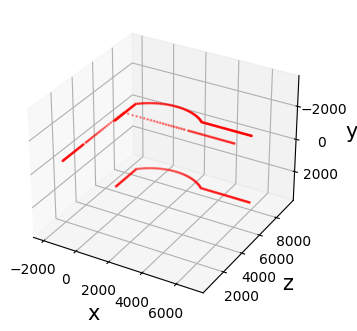

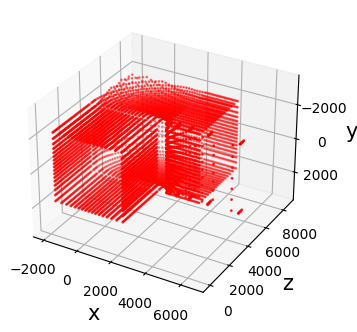

In [5]:
utils.plot_points(np.hstack(spot_laser_three.P))
utils.plot_points(np.hstack(ring_laser.P))

3点法 


In [6]:
simulator_params = {
    "A": A,
    "spot_laser": spot_laser_three,
    "ring_laser": ring_laser,
    "cMr": cMr,
    "idx_length": 90,
    "idx_period": 5,
    "round_threshold": 0.5,
    "is_bundle": True,
    "is_scale_true": False,
    "name": "運動直進，スポットレーザはみ出しなし",
}

S = Simulator(simulator_params)
S.run_preprocess()
S.run_measurement()


# S.show_result(is_groundtruth=False)
# S.show_result(is_groundtruth=True)

# S.plot_pose()

[[-1.0525725   0.          0.        ]
 [ 0.          0.51283875 -0.51283875]
 [ 1.          1.          1.        ]] [[0.]
 [0.]
 [1.]]
1.0 -1.0 -1.0 0.7369964164984375 -1.0 -1.0 1.0 -1.0 -1.0 1.0
[[nan nan nan  0.]
 [nan nan nan  0.]
 [nan nan nan  1.]
 [ 0.  0.  0.  1.]]


/Users/higuchi/dev/InchwormMeasurement/inchworm_measurement/utils.py:254: RuntimeWarning: invalid value encountered in scalar divide
  x_a = (-B + np.sqrt(B * B - 4 * A * C)) / (2 * A)
/Users/higuchi/dev/InchwormMeasurement/inchworm_measurement/utils.py:255: RuntimeWarning: invalid value encountered in scalar divide
  x_b = (-B - np.sqrt(B * B - 4 * A * C)) / (2 * A)


LinAlgError: Singular matrix

In [186]:
S.run_measurement()

[[-1.0525725   0.          0.        ]
 [ 0.          0.51283875 -0.51283875]
 [ 1.          1.          1.        ]] [[0.]
 [0.]
 [1.]]
1.0 -1.0 -1.0 0.7369964164984375 -1.0 -1.0 1.0 -1.0 -1.0 1.0
[[nan nan nan  0.]
 [nan nan nan  0.]
 [nan nan nan  1.]
 [ 0.  0.  0.  1.]]


/Users/higuchi/dev/InchwormMeasurement/inchworm_measurement/utils.py:254: RuntimeWarning: invalid value encountered in scalar divide
  print(A, B, C)
/Users/higuchi/dev/InchwormMeasurement/inchworm_measurement/utils.py:255: RuntimeWarning: invalid value encountered in scalar divide
  


LinAlgError: Singular matrix

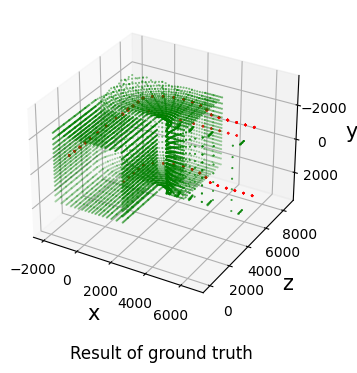

In [187]:
S.show_result(is_groundtruth=True)

In [174]:
# S.wP_spot_true
spot_laser_three.P

[array([[-2000.00000000000, 0, 0],
        [0, 2000.00000000000, -2000.00000000000],
        [1900.00000000000, 3900.00000000000, 3900.00000000000]],
       dtype=object),
 array([[-2000.00000000000, 0, 0],
        [0, 2000.00000000000, -2000.00000000000],
        [2000.00000000000, 4000.00000000000, 4000.00000000000]],
       dtype=object),
 array([[-2000.00000000000, 0, 0],
        [0, 2000.00000000000, -2000.00000000000],
        [2100.00000000000, 4100.00000000000, 4100.00000000000]],
       dtype=object),
 array([[-2000.00000000000, 0, 0],
        [0, 2000.00000000000, -2000.00000000000],
        [2200.00000000000, 4200.00000000000, 4200.00000000000]],
       dtype=object),
 array([[-2000.00000000000, 0, 0],
        [0, 2000.00000000000, -2000.00000000000],
        [2300.00000000000, 4300.00000000000, 4300.00000000000]],
       dtype=object),
 array([[-2000.00000000000, 0, 0],
        [0, 2000.00000000000, -2000.00000000000],
        [2400.00000000000, 4400.00000000000, 4400.00000

In [114]:
len(S.wMc_true)

108

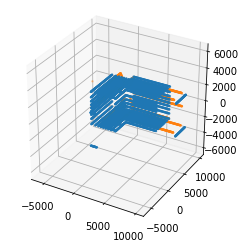

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
x = np.hstack(ring_laser.P).T
y = np.hstack(spot_laser_five.P).T

ax.scatter(x[:, 0], x[:, 2], x[:, 1], s=2)
ax.scatter(y[:, 0], y[:, 2], y[:, 1], s=2)
ax.set_aspect("equal")
ax.set_box_aspect([1, 1, 1])
# ax.view_init(elev=90, azim=60)
plt.show()

In [27]:
x = np.array(
    [
        [1090.66121336060, 0],
        [570.822511859336, 988.693592644457],
        [-570.822511859335, 988.693592644457],
        [-1090.66121336060, 1.33567476389623e-13],
        [-570.822511859336, -988.693592644457],
        [570.822511859336, -988.693592644457],
    ]
).T

round_threshold = 0.5
uv = round_threshold * np.round(x / round_threshold)

５点法(回転)


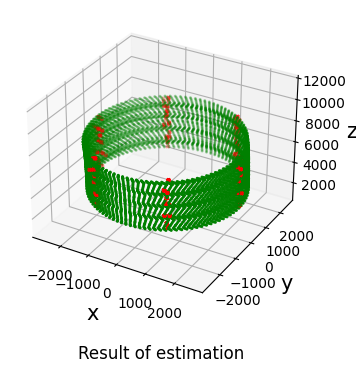

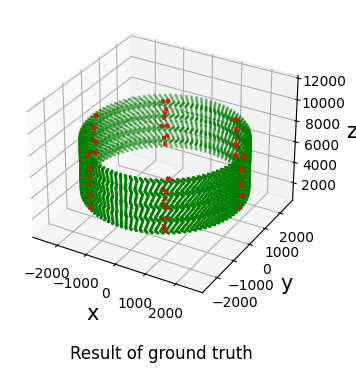

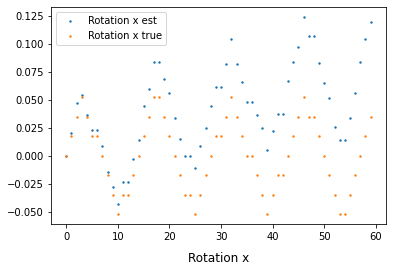

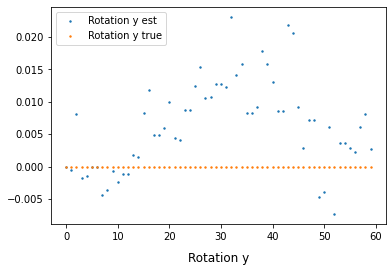

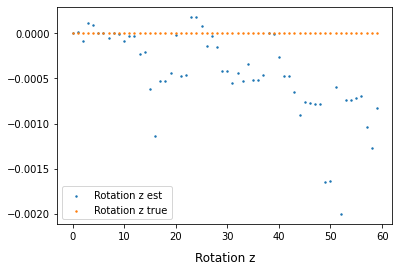

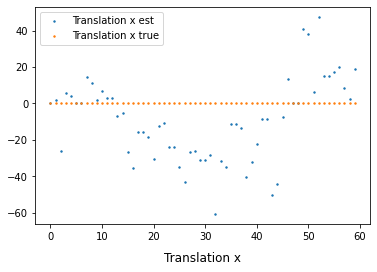

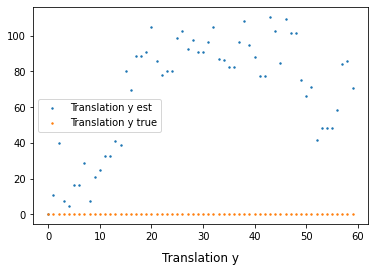

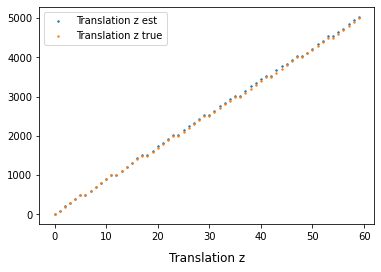

In [75]:
base_motion = []
for i in range(1000):
    max_deg = 3
    deg = np.min([(i + max_deg) % (max_deg * 4), (-(i + max_deg) % (max_deg * 4))]) - max_deg
    R = Rotation.from_rotvec([deg * np.pi / 180, 0, 0]).as_matrix()
    t = np.array([[0, 0, 100 * i]]).T
    base_motion.append(np.vstack([np.hstack([R, t]), np.array([[0, 0, 0, 1]])]))
base_motion = np.array(base_motion)

spot_offset = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 1000], [0, 0, 0, 1]])
ring_offset = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 3250], [0, 0, 0, 1]])

n = 6
spot_origin = np.zeros((3, n))
spot_direction = np.array(
    [[np.cos(i * np.pi / n * 2), np.sin(i * np.pi / n * 2), 1] for i in range(n)]
).T

m = 100
ring_origin = np.zeros((3, m))
ring_direction = np.array(
    [[np.cos(i * np.pi / m * 2), np.sin(i * np.pi / m * 2), 0] for i in range(m)]
).T

simulator_params = {
    "A": A,
    "spot_laser": Laser(spot_origin, spot_direction),
    "ring_laser": Laser(ring_origin, ring_direction),
    "spot_offset": spot_offset,
    "ring_offset": ring_offset,
    "surface_functions_eq": surface_functions_eq,
    "surface_functions_ineq": surface_functions_ineq,
    "base_motion": base_motion,
    "is_ring_with_camera": True,
    "idx_length": 10,
    "idx_period": 5,
    "round_threshold": 0.5,
    "is_three_points_algorithm": False,
    "is_bundle": True,
    "is_5points_true": False,
    "is_scale_true": False,
    "name": "運動直進，スポットレーザはみ出しなし",
}

S = Simulator(simulator_params)
S.run()

zlim = [500, 12000]
S.show_result(zlim=zlim)
S.show_result(zlim=zlim, is_groundtruth=True)

S.plot_pose()

３点法（直進，はみ出しなし）


0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
37.42099747784854


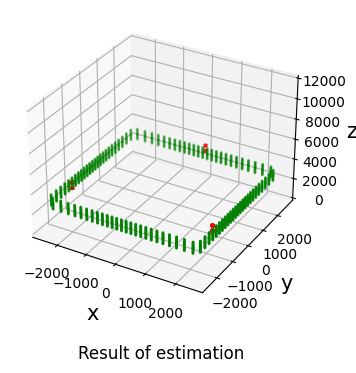

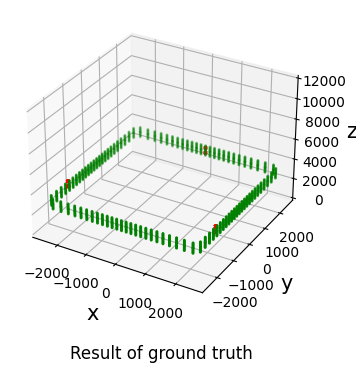

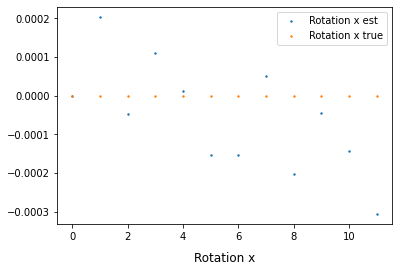

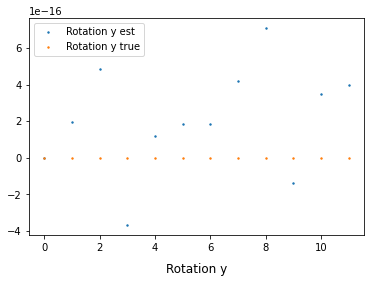

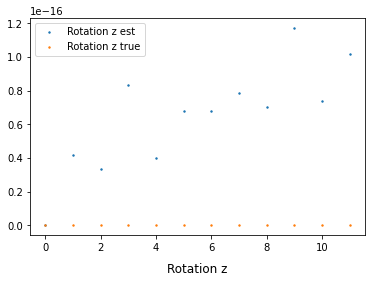

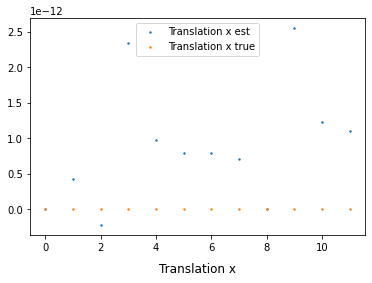

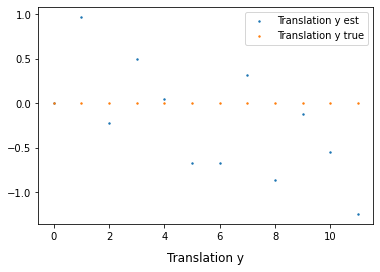

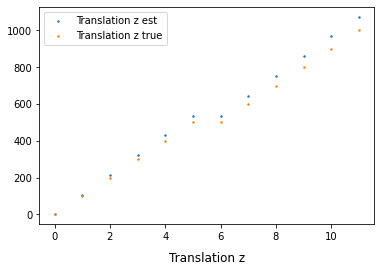

In [42]:
sigma = 0.00489  # size of pixel [mm] (nikon D800)
focal = 8  # length of focal [mm] (NIKKOR 8-15mm f/3.5-4.5E)

A = np.array([[focal / sigma, 0, 0], [0, focal / sigma, 0], [0, 0, 1]])
base_motion = np.array(
    [[[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 100 * i], [0, 0, 0, 1]] for i in range(11)]
)
spot_offset = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 1000], [0, 0, 0, 1]])
ring_offset = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 2500], [0, 0, 0, 1]])

spot_origin = np.zeros((3, 3))
spot_direction = np.array(
    [
        [0, np.sqrt(2) / np.sqrt(3), 1 / np.sqrt(3)],
        [1 / np.sqrt(2), -1 / np.sqrt(6), 1 / np.sqrt(3)],
        [-1 / np.sqrt(2), -1 / np.sqrt(6), 1 / np.sqrt(3)],
    ]
).T

m = 100
ring_origin = np.zeros((3, m))
ring_direction = np.array(
    [[np.cos(i * np.pi / m * 2), np.sin(i * np.pi / m * 2), 0] for i in range(m)]
).T

simulator_params = {
    "A": A,
    "spot_laser": Laser(spot_origin, spot_direction),
    "ring_laser": Laser(ring_origin, ring_direction),
    "spot_offset": spot_offset,
    "ring_offset": ring_offset,
    "surface_functions_eq": surface_functions_eq,
    "surface_functions_ineq": surface_functions_ineq,
    "base_motion": base_motion,
    "is_ring_with_camera": True,
    "idx_length": 10,
    "idx_period": 5,
    "round_threshold": 0.5,
    "is_three_points_algorithm": True,
    "is_bundle": True,
    "is_5points_true": False,
    "is_scale_true": False,
    "name": "運動直進，スポットレーザはみ出しなし",
}

S = Simulator(simulator_params)
S.run()
print(S.error)

zlim = [0, 12000]
S.show_result(zlim=zlim)
S.show_result(zlim=zlim, is_groundtruth=True)

S.plot_pose()

３点法（直進，はみ出しあり）


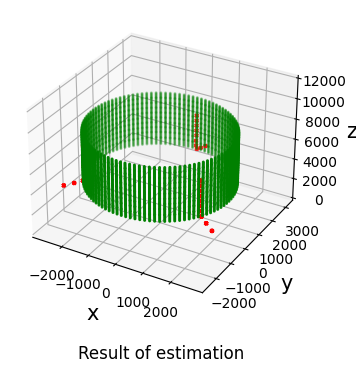

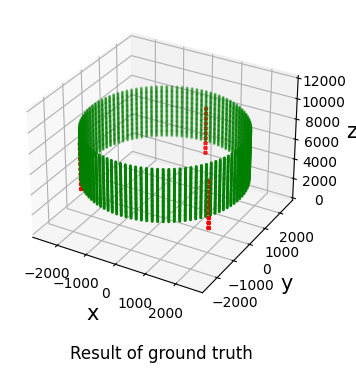

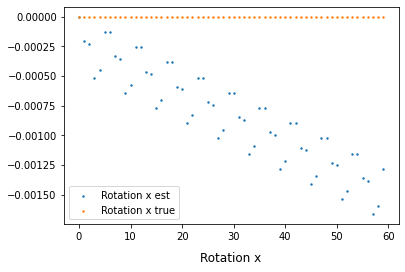

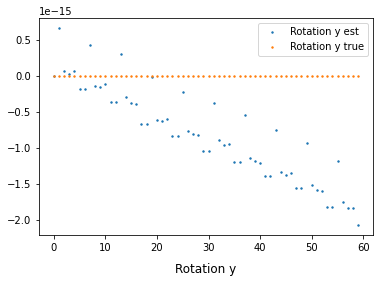

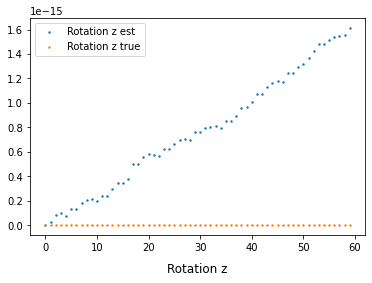

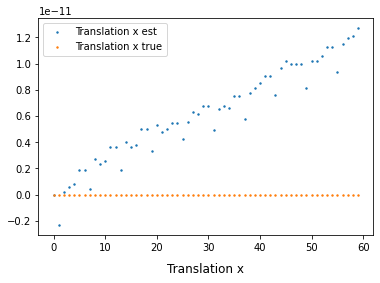

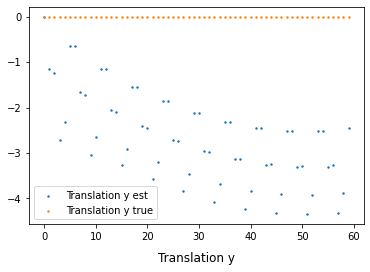

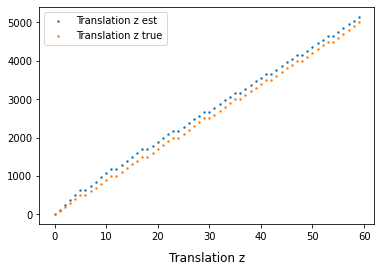

In [67]:
sigma = 0.00489  # size of pixel [mm] (nikon D800)
focal = 8  # length of focal [mm] (NIKKOR 8-15mm f/3.5-4.5E)

A = np.array([[focal / sigma, 0, 0], [0, focal / sigma, 0], [0, 0, 1]])
base_motion = np.array(
    [[[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 100 * i], [0, 0, 0, 1]] for i in range(1000)]
)
spot_offset = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 1000], [0, 0, 0, 1]])
ring_offset = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 4000], [0, 0, 0, 1]])

spot_origin = np.zeros((3, 3))
spot_direction = np.array(
    [
        [0, np.sqrt(2) / np.sqrt(3), 1 / np.sqrt(3)],
        [1 / np.sqrt(2), -1 / np.sqrt(6), 1 / np.sqrt(3)],
        [-1 / np.sqrt(2), -1 / np.sqrt(6), 1 / np.sqrt(3)],
    ]
).T

m = 100
ring_origin = np.zeros((3, m))
ring_direction = np.array(
    [[np.cos(i * np.pi / m * 2), np.sin(i * np.pi / m * 2), 0] for i in range(m)]
).T

simulator_params = {
    "A": A,
    "spot_laser": Laser(spot_origin, spot_direction),
    "ring_laser": Laser(ring_origin, ring_direction),
    "spot_offset": spot_offset,
    "ring_offset": ring_offset,
    "surface_functions_eq": surface_functions_eq,
    "surface_functions_ineq": surface_functions_ineq,
    "base_motion": base_motion,
    "is_ring_with_camera": True,
    "idx_length": 10,
    "idx_period": 5,
    "round_threshold": 0.5,
    "is_three_points_algorithm": False,
    "is_bundle": True,
    "is_5points_true": False,
    "is_scale_true": False,
    "name": "運動直進，スポットレーザはみ出しあり",
}

S = Simulator(simulator_params)
S.run()
print(S.error)

zlim = [0, 12000]
S.show_result(zlim=zlim)
S.show_result(zlim=zlim, is_groundtruth=True)

S.plot_pose()

３点法（回転）


True
60.063263554906364


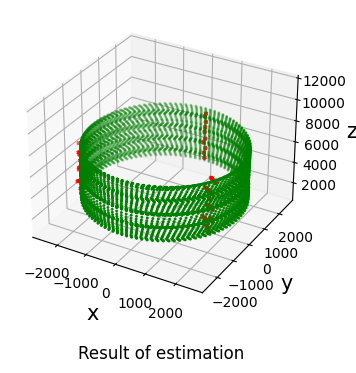

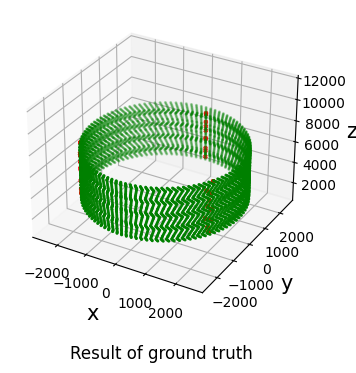

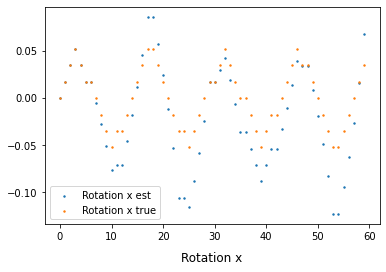

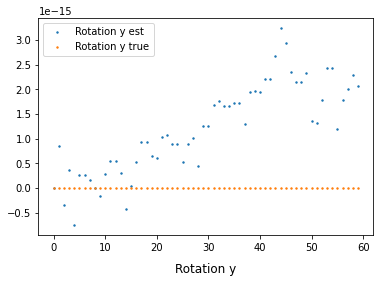

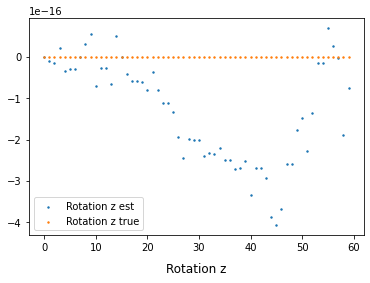

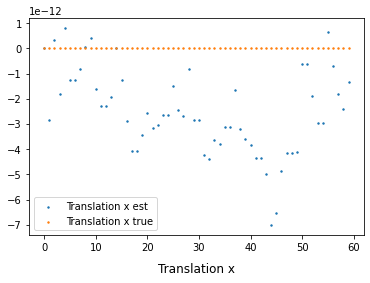

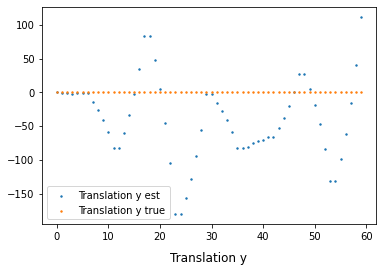

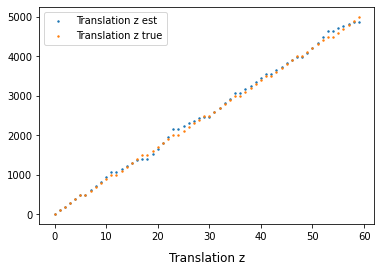

In [72]:
sigma = 0.00489  # size of pixel [mm] (nikon D800)
focal = 8  # length of focal [mm] (NIKKOR 8-15mm f/3.5-4.5E)

A = np.array([[focal / sigma, 0, 0], [0, focal / sigma, 0], [0, 0, 1]])
base_motion = []
for i in range(1000):
    max_deg = 3
    deg = np.min([(i + max_deg) % (max_deg * 4), (-(i + max_deg) % (max_deg * 4))]) - max_deg
    R = Rotation.from_rotvec([deg * np.pi / 180, 0, 0]).as_matrix()
    t = np.array([[0, 0, 100 * i]]).T
    base_motion.append(np.vstack([np.hstack([R, t]), np.array([[0, 0, 0, 1]])]))
base_motion = np.array(base_motion)

spot_offset = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 1000], [0, 0, 0, 1]])
ring_offset = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 2500], [0, 0, 0, 1]])

spot_origin = np.zeros((3, 3))
spot_direction = np.array(
    [
        [0, np.sqrt(2) / np.sqrt(3), 1 / np.sqrt(3)],
        [1 / np.sqrt(2), -1 / np.sqrt(6), 1 / np.sqrt(3)],
        [-1 / np.sqrt(2), -1 / np.sqrt(6), 1 / np.sqrt(3)],
    ]
).T

m = 100
ring_origin = np.zeros((3, m))
ring_direction = np.array(
    [[np.cos(i * np.pi / m * 2), np.sin(i * np.pi / m * 2), 0] for i in range(m)]
).T

print((np.eye(4) == np.eye(4)).all())
simulator_params = {
    "A": A,
    "spot_laser": Laser(spot_origin, spot_direction),
    "ring_laser": Laser(ring_origin, ring_direction),
    "spot_offset": spot_offset,
    "ring_offset": ring_offset,
    "surface_functions_eq": surface_functions_eq,
    "surface_functions_ineq": surface_functions_ineq,
    "base_motion": base_motion,
    "is_ring_with_camera": True,
    "idx_length": 10,
    "idx_period": 5,
    "round_threshold": 0.5,
    "is_three_points_algorithm": False,
    "is_bundle": True,
    "is_5points_true": False,
    "is_scale_true": False,
    "name": "運動回転",
}

S = Simulator(simulator_params)
S.run()
print(S.error)

zlim = [500, 12000]
S.show_result(zlim=zlim)
S.show_result(zlim=zlim, is_groundtruth=True)

S.plot_pose()

In [71]:
S.calc_error()

In [35]:
for i in range(1000):
    max_deg = 3
    deg = np.min([(i + max_deg) % (max_deg * 4), (-(i + max_deg) % (max_deg * 4))]) - max_deg
    print(deg)

0
1
2
3
2
1
0
-1
-2
-3
-2
-1
0
1
2
3
2
1
0
-1
-2
-3
-2
-1
0
1
2
3
2
1
0
-1
-2
-3
-2
-1
0
1
2
3
2
1
0
-1
-2
-3
-2
-1
0
1
2
3
2
1
0
-1
-2
-3
-2
-1
0
1
2
3
2
1
0
-1
-2
-3
-2
-1
0
1
2
3
2
1
0
-1
-2
-3
-2
-1
0
1
2
3
2
1
0
-1
-2
-3
-2
-1
0
1
2
3
2
1
0
-1
-2
-3
-2
-1
0
1
2
3
2
1
0
-1
-2
-3
-2
-1
0
1
2
3
2
1
0
-1
-2
-3
-2
-1
0
1
2
3
2
1
0
-1
-2
-3
-2
-1
0
1
2
3
2
1
0
-1
-2
-3
-2
-1
0
1
2
3
2
1
0
-1
-2
-3
-2
-1
0
1
2
3
2
1
0
-1
-2
-3
-2
-1
0
1
2
3
2
1
0
-1
-2
-3
-2
-1
0
1
2
3
2
1
0
-1
-2
-3
-2
-1
0
1
2
3
2
1
0
-1
-2
-3
-2
-1
0
1
2
3
2
1
0
-1
-2
-3
-2
-1
0
1
2
3
2
1
0
-1
-2
-3
-2
-1
0
1
2
3
2
1
0
-1
-2
-3
-2
-1
0
1
2
3
2
1
0
-1
-2
-3
-2
-1
0
1
2
3
2
1
0
-1
-2
-3
-2
-1
0
1
2
3
2
1
0
-1
-2
-3
-2
-1
0
1
2
3
2
1
0
-1
-2
-3
-2
-1
0
1
2
3
2
1
0
-1
-2
-3
-2
-1
0
1
2
3
2
1
0
-1
-2
-3
-2
-1
0
1
2
3
2
1
0
-1
-2
-3
-2
-1
0
1
2
3
2
1
0
-1
-2
-3
-2
-1
0
1
2
3
2
1
0
-1
-2
-3
-2
-1
0
1
2
3
2
1
0
-1
-2
-3
-2
-1
0
1
2
3
2
1
0
-1
-2
-3
-2
-1
0
1
2
3
2
1
0
-1
-2
-3
-2
-1
0
1
2
3
2
1
0
-1
-2
-3
-2
-1
0
1
2
3
2
1
0
